# Bias field correction

Attempt 1 : use sitk

### import libraries

In [1]:
import os       # using operating system dependent functionality (folders)
import glob
import pandas as pd # data analysis and manipulation
import numpy as np    # numerical computing (manipulating and performing operations on arrays of data)
import copy     # Can Copy and Deepcopy files so original file is untouched.
from ipywidgets import IntSlider, Output
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import SimpleITK as sitk
import skimage
import hashlib
import sys
sys.path.insert(0, '../') # path to functions
from brainspin import file_handler as fh # 
from brainspin import mold #
from brainspin import carve
from brainspin.file_handler import Config

### Try on a 2d image

In [2]:
### Let's see how it works on a nifti

In [3]:
config = Config()
root_mri_directory = config.get_directory('root_mri_directory')
mri_pattern = os.path.join(root_mri_directory, '**/*.gz')
gz_files = glob.glob(mri_pattern, recursive=True)

In [4]:

def show_me_debiased(image_filename):
    # reading in on sitk.sitkUInt8 may be wrong, but anyways
    inputImage = sitk.ReadImage(image_filename,sitk.sitkUInt8)

    maskImage = sitk.OtsuThreshold( inputImage, 0, 1, 200 )

    inputImage = sitk.Cast( inputImage, sitk.sitkFloat32 )

    corrector = sitk.N4BiasFieldCorrectionImageFilter();

    numberFittingLevels = 4

    output = corrector.Execute( inputImage, maskImage )

    outputCasted = sitk.Cast(output,sitk.sitkVectorUInt8)
    
    return outputCasted

In [5]:
outputCasted = show_me_debiased('test/N4BiasFieldCorrection_input_image.png')
inputImage = sitk.ReadImage('test/N4BiasFieldCorrection_input_image.png',sitk.sitkUInt8)

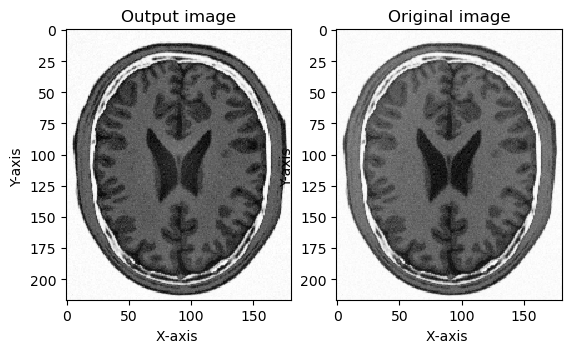

In [6]:
npa = sitk.GetArrayViewFromImage(outputCasted)
opa = sitk.GetArrayViewFromImage(inputImage)
plt.subplot(1, 2, 1) # row 1, col 2 index 1
plt.imshow(npa,cmap='Greys',  interpolation='nearest')
plt.title("Output image")
plt.xlabel('X-axis ')
plt.ylabel('Y-axis ')

plt.subplot(1, 2, 2) # index 2
plt.imshow(opa,cmap='Greys',  interpolation='nearest')
plt.title("Original image")
plt.xlabel('X-axis ')
plt.ylabel('Y-axis ')

plt.show()

In [7]:
outputCasted = show_me_debiased(gz_files[0])


# Read the .nii image containing the volume with SimpleITK:
t1_fn = gz_files[0]
sitk_t1 = sitk.ReadImage(t1_fn)

# and access the numpy array:
t1 = sitk.GetArrayFromImage(sitk_t1)

In [8]:
mold.SliceViewer(t1)

interactive(children=(Dropdown(description='View:', options=('axial', 'sag', 'cor'), value='axial'), Output())…

In [9]:
#sitk.GetArrayFromImage?

In [10]:
output = sitk.GetArrayFromImage(outputCasted)

In [11]:
mold.SliceViewer(output)

interactive(children=(Dropdown(description='View:', options=('axial', 'sag', 'cor'), value='axial'), Output())…